In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import torchvision.datasets as D
import torch.nn.functional as F
import numpy as np
import pickle
from matplotlib import pyplot as plt
import sys
sys.path.append("..")
from utils.utils import MyDataset, show_image, visualise_output, visualise_output_reward
from networks.autoencoder import FireAutoencoder
from networks.autoencoder_reward import FireAutoencoder_reward
from sklearn.decomposition import PCA
import matplotlib
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting toolkit

In [2]:
train_dataset = MyDataset(root='../../data/complete_random/homo_2/Sub20x20_full_grid_.pkl',
                             tform=lambda x: torch.from_numpy(x, dtype=torch.float
))

In [3]:
latent_dims = 256
capacity = latent_dims//2
input_size = 20
epochs = 100
sigmoid = True
net = FireAutoencoder_reward(capacity, input_size, latent_dims, temperature_1 = 1000, temperature_2 = 1e6, normalize = True)
net.load_state_dict(torch.load(f'../weights/AE_Reward/homo_2_sub20x20_latent=256_capacity=128_100_sigmoid=False_T1=1000.0_T2=1000000.0_lr1=1e-05_lr2=0.0001_lr3=1e-05_normalize=True_weight_decay=0.0.pth', map_location=torch.device('cpu') ))

<All keys matched successfully>

In [4]:
total_params = sum(p.numel() for p in net.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 4394692


In [5]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=False)

In [6]:
images, r = next(iter(train_loader))

Original images


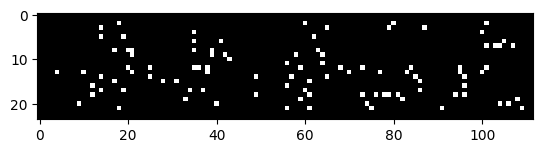

In [7]:
print('Original images')
show_image(torchvision.utils.make_grid(images[0:5],5))
plt.show()

Reconstruction:


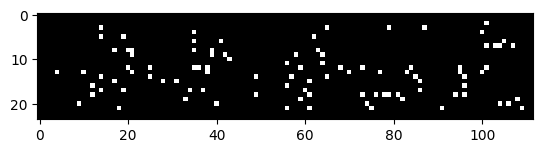

In [8]:
print('Reconstruction:')
visualise_output_reward(images, r, net, 5, 5)

In [4]:
full_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)

In [5]:
all_images, all_r = next(iter(full_loader))

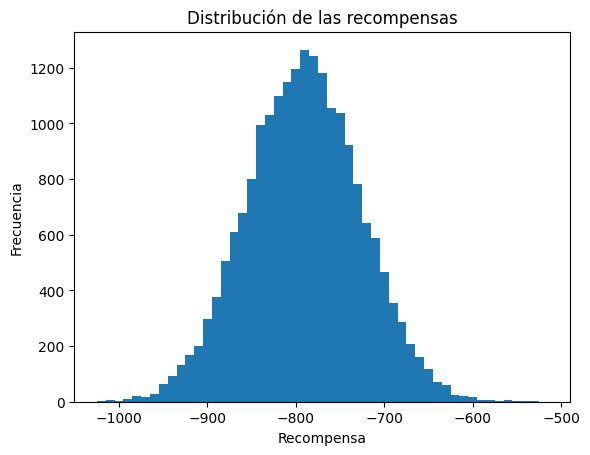

In [6]:
bins = np.arange(-1020, -500, 10)
plt.hist(all_r, bins=bins, align='left')
plt.title('Distribución de las recompensas')
plt.xlabel('Recompensa')
plt.ylabel('Frecuencia')
plt.savefig(f"reward_distr.png")
plt.show()

In [12]:
encoded_images = net.encode(all_images)

In [13]:
all_r.apply_(lambda x: 2 if x > -700 else 1 if (x > -900) else 0)

tensor([1., 1., 1.,  ..., 1., 2., 1.])

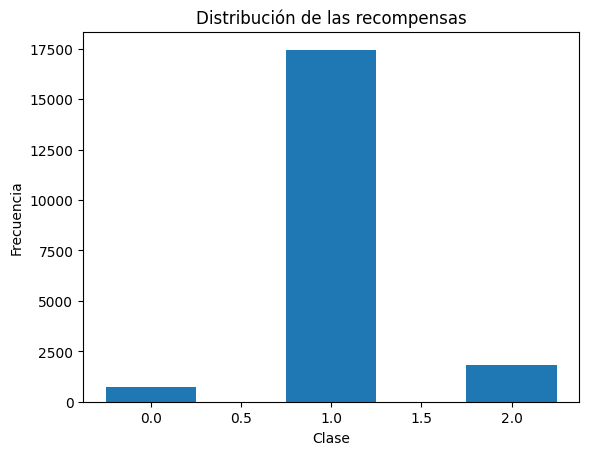

In [14]:
bins = np.arange(0, 3, 0.5)
plt.hist(all_r, bins=bins, align='left')
plt.title('Distribución de las recompensas')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.savefig(f"reward_classes_distr.png")
plt.show()

In [15]:
pca = PCA(n_components=3)
with torch.no_grad():
    encoded_3d_pca = pca.fit_transform(encoded_images)

In [16]:
colors = ['green', 'blue', 'red']
classes = ['small', 'medium', 'large']

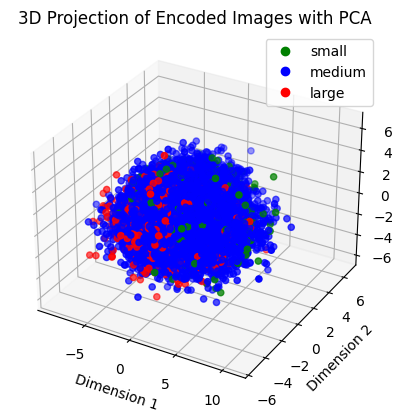

In [17]:
# Create a 3D scatter plot of the 3D representations
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the points
scatter = ax.scatter(encoded_3d_pca[:, 0], encoded_3d_pca[:, 1], encoded_3d_pca[:, 2],c=all_r, cmap=matplotlib.colors.ListedColormap(colors))

ax.set_title('3D Projection of Encoded Images with PCA')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.savefig(f"latent_space/AE_Reward/homo_2_sub20x20_pca_latent={latent_dims}_capacity={capacity}_{epochs}.png")
plt.show()

In [18]:
tsne = TSNE(n_components=3)
with torch.no_grad():
    encoded_3d_tsne = tsne.fit_transform(encoded_images)

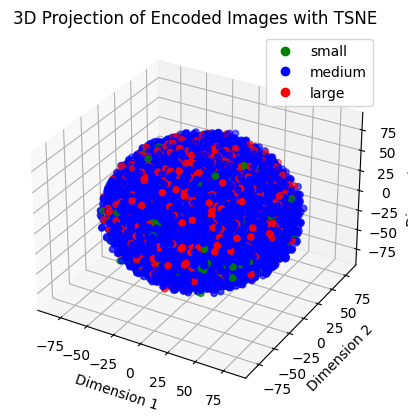

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the points
scatter = ax.scatter(encoded_3d_tsne[:, 0], encoded_3d_tsne[:, 1], encoded_3d_tsne[:, 2],c=all_r, cmap=matplotlib.colors.ListedColormap(colors))

ax.set_title('3D Projection of Encoded Images with TSNE')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.savefig(f"latent_space/AE_Reward/homo_2_sub20x20_tsne_latent={latent_dims}_capacity={capacity}_{epochs}.png")
plt.show()

In [23]:
f = open("train_stats/AE_Reward/test_losses.txt", "r")
a = f.read()

In [24]:
latent_dims = []
test_losses = []
for a in a.split('\n')[:-1]:
    latent_dims.append(int(a.split(',')[0]))
    test_losses.append(float(a.split(',')[2]))

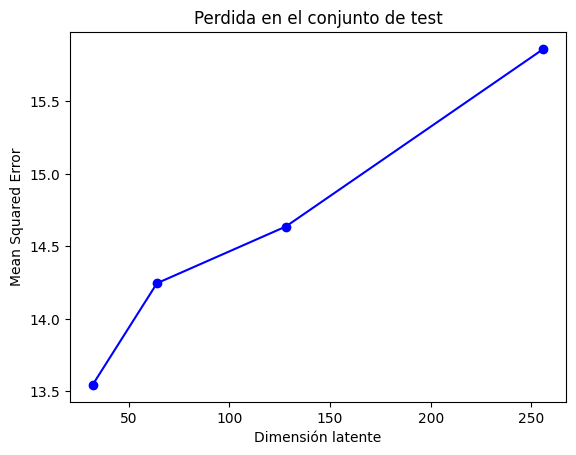

In [25]:
plt.plot(latent_dims,test_losses, marker='o', color='b'
)
plt.title("Perdida en el conjunto de test")
plt.xlabel("Dimensión latente")
plt.ylabel("Mean Squared Error")
plt.savefig(f"train_stats/AE_Reward/test_loss_compare.png")
plt.show()
